# **0.1 Imports**

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display       import Image
from matplotlib            import rcParams
import matplotlib.pyplot   as plt

import scipy.stats             as ss
from scipy.stats               import chi2_contingency 
from scipy.special import boxcox1p
from scipy.special import inv_boxcox1p
from sklearn.preprocessing import PowerTransformer
import statsmodels.api         as sm
from category_encoders         import TargetEncoder
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics           import mean_absolute_error, mean_squared_error,make_scorer, mean_absolute_percentage_error
from sklearn.model_selection   import cross_val_predict, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing     import RobustScaler,MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.cluster           import AgglomerativeClustering, KMeans
from sklearn.ensemble          import RandomForestRegressor,RandomForestClassifier
from sklearn                   import mixture       as mx
from sklearn                   import ensemble         as en
from sklearn.feature_extraction.text import CountVectorizer
from xgboost                   import XGBRegressor
from catboost                  import CatBoostRegressor
import optuna
import pickle

## **0.1.1 Helper functions**

In [5]:
# def mean_absolute_percentage_error_func(y, yhat):
#     mask = y != 0
#     return np.mean(np.abs(np.where(mask, (y - yhat) / y, 0)))
def mean_absolute_percentage_error_func(y, yhat):
    total_error = 0
    count = 0

    for yi, yhati in zip(y, yhat):
        if yi != 0:
            total_error += np.abs((yi - yhati) / yi)
            count += 1

    if count == 0:
        return 0  # Avoid division by zero

    return total_error / count
    
def mae_scorer(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)  # Negativo porque cross_val_score espera escores mais altos

def mape_scorer(y_true, y_pred):
    return -np.mean(np.abs((y_true - y_pred) / y_true))

def mape_scorer(y_true, y_pred):
    mask = y_true != 0  # Cria uma máscara para evitar divisão por zero
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    if len(y_true_masked) == 0:
        # Caso não haja valores diferentes de zero, retorne 0 (ou outro valor apropriado)
        return 0.0

    return -np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked))

def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_cramers_v_matrix(dataframe):
    cols = dataframe.columns
    cramers_v_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

    for i in range(len(cols)):
        for j in range(len(cols)):
            if i == j:
                cramers_v_matrix.iloc[i, j] = 1.0
            else:
                cramers_v = calculate_cramers_v(dataframe[cols[i]], dataframe[cols[j]])
                cramers_v_matrix.iloc[i, j] = cramers_v
                cramers_v_matrix.iloc[j, i] = cramers_v

    return cramers_v_matrix

def calculate_cramers_v(var1, var2):
    contingency_table = pd.crosstab(var1, var2)
    
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def count_words (list):
    # Crie um objeto CountVectorizer
    vectorizer = CountVectorizer()
    
    # Ajuste e transforme os dados 'nome' usando o vetorizador
    X = vectorizer.fit_transform(list['nome'])
    
    # Obtenha os nomes das features (palavras)
    feature_names = vectorizer.get_feature_names_out()
    
    # Crie um DataFrame com as palavras e suas contagens
    word_counts = pd.DataFrame({
        'palavra': feature_names,
        'contagem': X.toarray().sum(axis=0)
    })
    
    # Ordene o DataFrame pelas contagens em ordem decrescente
    word_counts = word_counts.sort_values('contagem', ascending=False)
    
    return word_counts


high_price = ['townhouse', 'luxury','hidde2','penthouse', 'chelsea', 'superbowl',
                     'suite', 'soho', 'duplex', 'events', 'tribeca', 'film',
                     'service', 'tower', 'beekman', '3br', 'terrace']

low_price=['1br','harlem','br' , 'near','bushwick', 'harlem','close', 'subway', 
       'train','bushwick', 'shared', 'subway', 'train', 'close', 'jfk',
       'heights', 'comfortable', 'lga', 'queens']

def categorize_listing(row):
    if row['bairro_group'] == 'Manhattan' and row['room_type'] == 'Entire home/apt' and any(keyword in row['nome'] for keyword in high_price):
        return 'classy'
    elif row['bairro_group'] in ['Queens', 'Bronx'] and row['room_type'] in ['Private room', 'Shared room'] and any(keyword in row['nome'] for keyword in low_price):
        return 'simple'
    else:
        return 'normal'


def haversine_distance(df, lat_d, lon_d):
    lat_p, lon_p = df['latitude'], df['longitude']
    radius = 6371 # km

    dlat = np.radians(lat_d - lat_p)
    dlon = np.radians(lon_d - lon_p)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat_p)) * np.cos(np.radians(lat_d)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = radius * c

    return distance

def mean_percentage_error(y,yhat):
    return np.mean((y-yhat)/y)

def filter_mean(df,bairro_group,bairro,room_type):
    filter = (df['bairro_group'] == bairro_group) & (df['bairro'] == bairro) & (df['room_type'] == room_type)
    aux = df[filter]

    # Calculando a média de preço
    mean = aux['price'].mean()
    return round(mean)

# **Training**

In [14]:
df_raw=pd.read_csv('../datasets/raw.csv')

def train_results(df):

    df=df_raw.copy()
    
    x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df, 
                                                            target = 'price', 
                                                            train_size=0.8, valid_size=0.1, test_size=0.1,
                                                            random_state=42)

    df = pd.concat ([x_train, y_train], axis=1).reset_index(drop=True) 

    # change types======================================================
    df['ultima_review'] = pd.to_datetime(df['ultima_review'])
    x_val['ultima_review'] = pd.to_datetime(x_val['ultima_review'])

    # nas===============================================================
    df['reviews_por_mes'] = np.where(df['reviews_por_mes'].isna(), 0, df['reviews_por_mes'])
    x_val['reviews_por_mes'] = np.where(x_val['reviews_por_mes'].isna(), 0, x_val['reviews_por_mes'])
    
    cols = ['nome','host_name']
    df[cols] = np.where(df[cols].isna(), 'desconhecido', df[cols])
    x_val[cols] = np.where(x_val[cols].isna(), 'desconhecido', x_val[cols])

    # feature creation==========================================================
    # ultima review
    # preenchendo nans com um dia depois da última data do dataset 
    df['ultima_review'] = df['ultima_review'].fillna('2019-07-09')
    x_val['ultima_review'] = x_val['ultima_review'].fillna('2019-07-09')  
    # calculando a diferença de dias desde o dia mais recente até a última review
    ref_date = pd.to_datetime('2019-07-09')
    df['ultima_review'] = (df['ultima_review'] - ref_date).dt.days * -1
    x_val['ultima_review'] = (x_val['ultima_review'] - ref_date).dt.days * -1

    # filtrando outlier do price
    df=df[df['price']<5000]

    # substituindo price igual 0 por médias
    mean1=filter_mean(df,'Brooklyn','Bushwick','Shared room')
    mean2=filter_mean(df,'Brooklyn','Williamsburg','Entire home/apt')
    mean3=filter_mean(df,'Brooklyn','Bedford-Stuyvesant','Private room')
    mean4=filter_mean(df,'Bronx','East Morrisania','Private room')
    mean5=filter_mean(df,'Brooklyn','Bedford-Stuyvesant','Private room')
    mean6=filter_mean(df,'Brooklyn','Greenpoint','Private room')
    mean7=filter_mean(df,'Manhattan','Murray Hill','Entire home/apt')
    
    df['price'] = np.where(df['id'] == 21291569, mean1, df['price'])
    df['price'] = np.where(df['id'] == 20624541, mean2, df['price'])
    df['price'] = np.where(df['id'] == 20639914, mean3, df['price'])
    df['price'] = np.where(df['id'] == 20333471, mean4, df['price'])
    df['price'] = np.where(df['id'] == 20639792, mean5, df['price'])
    df['price'] = np.where(df['id'] == 20639628, mean5, df['price'])
    df['price'] = np.where(df['id'] == 18750597, mean5, df['price'])
    df['price'] = np.where(df['id'] == 20608117, mean6, df['price'])
    df['price'] = np.where(df['id'] == 20933849, mean7, df['price'])

    # data preparation==================================================
    X_train=df.drop(['price'],axis=1)
    y_train=df['price']
    X_val=x_val.copy()

    # normalization
    pt = PowerTransformer(method='yeo-johnson')
    Y_train = y_train.values.reshape(-1, 1)
    pt.fit(Y_train)
    Y_train = np.array([Y_train])
    Y_train = boxcox1p(Y_train,pt.lambdas_)
    Y_train=Y_train.reshape(-1, 1)
    
    Y_val = y_val.values.reshape(-1, 1)
    pt.transform(Y_val)
    Y_val = np.array([Y_val])
    Y_val = boxcox1p(Y_val,pt.lambdas_)
    Y_val=Y_val.reshape(-1, 1)
    
    scaler = StandardScaler()
    Y_train = scaler.fit_transform(Y_train)
    Y_val = scaler.transform(Y_val)

    # endoding
    # bairro_group
    te = TargetEncoder(cols=['bairro_group'])
    X_train = te.fit_transform(X_train, y_train)
    X_val = te.transform(X_val)
    
    # bairro
    te = TargetEncoder(cols=['bairro'])
    X_train = te.fit_transform(X_train, y_train)
    X_val = te.transform(X_val)
    
    # room_type
    te = TargetEncoder(cols=['room_type'])
    X_train = te.fit_transform(X_train, y_train)
    X_val = te.transform(X_val)

    # feature selection==================================================
    X_train=X_train[['bairro', 'bairro_group','ultima_review','latitude','longitude',
       'minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count',
       'disponibilidade_365', 'room_type','reviews_por_mes']]

    X_val = X_val[X_train.columns]

    # model definition and training
    cat=CatBoostRegressor(logging_level='Silent').fit(X_train,y_train)
    
    # prediction
    cat_yhat=cat.predict(X_val)
    
    # prediction to original scale
    cat_yhat_= scaler.inverse_transform(cat_yhat.reshape(-1, 1))
    cat_yhat_= inv_boxcox1p(cat_yhat_, pt.lambdas_).flatten()
    
    mae_cat = mean_absolute_error                 (y_val, cat_yhat_)
    mape_cat = mean_absolute_percentage_error_func(y_val, cat_yhat_)
    mse_cat = mean_squared_error                  (y_val, cat_yhat_)
    rmse_cat = np.sqrt((mse_cat))

    final_result_cat = pd.DataFrame({'Model Name': 'CatBoost',
                           'MAE': mae_cat,
                           'MAPE': mape_cat,
                           'RMSE': rmse_cat}, index=[0])
    
    return final_result_cat

result = train_results(df_raw)
result

,Model Name,MAE,MAPE,RMSE
0,CatBoost,52.313421,0.304406,244.42243


# **Cross-validation**

In [72]:
df_raw=pd.read_csv('../datasets/raw.csv')

def cv_results(df):

    df=df_raw.copy()
    
    x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df, 
                                                            target = 'price', 
                                                            train_size=0.8, valid_size=0.1, test_size=0.1,
                                                            random_state=42)

    df = pd.concat ([x_train, y_train], axis=1).reset_index(drop=True) 

    # change types======================================
    df['ultima_review'] = pd.to_datetime(df['ultima_review'])

    # nas==================================================
    # reviews por mes
    df['reviews_por_mes'] = np.where(df['reviews_por_mes'].isna(), 0, df['reviews_por_mes'])
    
    # hostname
    cols = ['nome','host_name']
    df[cols] = np.where(df[cols].isna(), 'desconhecido', df[cols])

    # feature creation=============================================
    # ultima review
    # preenchendo nans com um dia depois da última data do dataset 
    df['ultima_review'] = df['ultima_review'].fillna('2019-07-09')
    # calculando a diferença de dias desde o dia mais recente até a última review
    ref_date = pd.to_datetime('2019-07-09')
    df['ultima_review'] = (df['ultima_review'] - ref_date).dt.days * -1

    # filtrando outlier do price===================================
    df=df[df['price']<5000]

    # substituindo price igual 0 por médias
    mean1=filter_mean(df,'Brooklyn','Bushwick','Shared room')
    mean2=filter_mean(df,'Brooklyn','Williamsburg','Entire home/apt')
    mean3=filter_mean(df,'Brooklyn','Bedford-Stuyvesant','Private room')
    mean4=filter_mean(df,'Bronx','East Morrisania','Private room')
    mean5=filter_mean(df,'Brooklyn','Bedford-Stuyvesant','Private room')
    mean6=filter_mean(df,'Brooklyn','Greenpoint','Private room')
    mean7=filter_mean(df,'Manhattan','Murray Hill','Entire home/apt')
    
    df['price'] = np.where(df['id'] == 21291569, mean1, df['price'])
    df['price'] = np.where(df['id'] == 20624541, mean2, df['price'])
    df['price'] = np.where(df['id'] == 20639914, mean3, df['price'])
    df['price'] = np.where(df['id'] == 20333471, mean4, df['price'])
    df['price'] = np.where(df['id'] == 20639792, mean5, df['price'])
    df['price'] = np.where(df['id'] == 20639628, mean5, df['price'])
    df['price'] = np.where(df['id'] == 18750597, mean5, df['price'])
    df['price'] = np.where(df['id'] == 20608117, mean6, df['price'])
    df['price'] = np.where(df['id'] == 20933849, mean7, df['price'])

    # data preparation===============================================
    X_train=df.drop(['price'],axis=1)
    y_train=df['price']

    # normalization
    pt = PowerTransformer(method='yeo-johnson')
    Y_train = y_train.values.reshape(-1, 1)
    pt.fit(Y_train)
    Y_train = np.array([Y_train])
    Y_train = boxcox1p(Y_train,pt.lambdas_)
    Y_train=Y_train.reshape(-1, 1)
    
    # encoders===========================================================
    # bairro_group
    te = TargetEncoder(cols=['bairro_group'])
    X_train = te.fit_transform(X_train, y_train)
    
    # bairro
    te = TargetEncoder(cols=['bairro'])
    X_train = te.fit_transform(X_train, y_train)
    
    # room_type
    te = TargetEncoder(cols=['room_type'])
    X_train = te.fit_transform(X_train, y_train)

    # feature selection===================================================  
    X_train=X_train[['bairro', 'bairro_group','ultima_review','latitude','longitude',
       'minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count',
       'disponibilidade_365', 'room_type','reviews_por_mes']]
        
    # model definition ======================================================
    cat_cv=CatBoostRegressor(logging_level='Silent')

    # kfolds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # prediction
    y_pred = cross_val_predict(cat_cv, X_train, Y_train, cv=kf)
    
    # prediction to original scale
    y_pred_= scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_pred_= inv_boxcox1p(y_pred_, pt.lambdas_).flatten()
    
    mae_cat_cv = mean_absolute_error(y_train, y_pred_)
    mape_cat_cv = mean_absolute_percentage_error_func(y_train, y_pred_)
    rmse_cat_cv = np.sqrt(mean_squared_error(y_train, y_pred_))
    
    std_mae = np.std(-mae_cat_cv)
    std_mape = np.std(-mape_cat_cv)
    std_rmse = np.std(-rmse_cat_cv)
    
    result_cat_cv = pd.DataFrame({'Model Name': 'CatBoost CV',
                                  'MAE': mae_cat_cv,
                                  'MAPE': mape_cat_cv,
                                  'RMSE': rmse_cat_cv}, index=[0])
    
    result_cat_cv
    
    return result_cat_cv

result = cv_results(df_raw)
result

,Model Name,MAE,MAPE,RMSE
0,CatBoost CV,53.084739,0.306991,154.318257


# **Test prediction**

In [40]:
df_raw=pd.read_csv('../datasets/raw.csv')

model=pickle.load(open('../model/model_lighthouse.pkl','rb'))
standard_scaler=pickle.load(open('../parameters/standard.pkl','rb'))
power_trans=pickle.load(open('../parameters/power_trans.pkl','rb'))
target_bairro=pickle.load (open('../parameters/target_bairro.pkl','rb'))
target_room_type=pickle.load (open('../parameters/target_room_type.pkl','rb'))
target_bairro_group=pickle.load (open('../parameters/target_bairro_group.pkl','rb'))

def test_results(df):

    df=df_raw.copy()
    
    x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df, 
                                                            target = 'price', 
                                                            train_size=0.8, valid_size=0.1, test_size=0.1,
                                                            random_state=42)
    
    # change types======================================================
    x_test['ultima_review'] = pd.to_datetime(x_test['ultima_review'])

    # nas===============================================================
    x_test['reviews_por_mes'] = np.where(x_test['reviews_por_mes'].isna(), 0, x_test['reviews_por_mes'])
    
    cols = ['nome','host_name']
    x_test[cols] = np.where(x_test[cols].isna(), 'desconhecido', x_test[cols])

    # feature creation==========================================================
    # ultima review
    # preenchendo nans com um dia depois da última data do dataset 
    x_test['ultima_review'] = x_test['ultima_review'].fillna('2019-07-09')  
    # calculando a diferença de dias desde o dia mais recente até a última review
    ref_date = pd.to_datetime('2019-07-09')
    x_test['ultima_review'] = (x_test['ultima_review'] - ref_date).dt.days * -1

    # data preparation==================================================
    X_test=x_test.copy()

    # normalization    
    Y_test = y_test.values.reshape(-1, 1)
    power_trans.transform(Y_test)
    Y_test = np.array([Y_test])
    Y_test = boxcox1p(Y_test,power_trans.lambdas_)
    Y_test=Y_test.reshape(-1, 1)
    
    Y_test = standard_scaler.transform(Y_test)

    # encoding
    # bairro_group
    X_test = target_bairro_group.transform(X_test)
    
    # bairro
    X_test = target_bairro.transform(X_test)
    
    # room_type
    X_test = target_room_type.transform(X_test)

    # feature selection==================================================
    X_test = X_test[['bairro', 'bairro_group','ultima_review','latitude','longitude',
       'minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count',
       'disponibilidade_365', 'room_type','reviews_por_mes']]

    # prediction
    cat_yhat=model.predict(X_test)

    # prediction to original scale
    cat_yhat_= standard_scaler.inverse_transform(cat_yhat.reshape(-1, 1))
    cat_yhat_= inv_boxcox1p(cat_yhat_, power_trans.lambdas_).flatten()
    
    mae_cat = mean_absolute_error                 (y_test, cat_yhat_)
    mape_cat = mean_absolute_percentage_error_func(y_test, cat_yhat_)
    mse_cat = mean_squared_error                  (y_test, cat_yhat_)
    rmse_cat = np.sqrt((mse_cat))
    
    final_result_cat = pd.DataFrame({'Model Name': 'CatBoost',
                           'MAE': mae_cat,
                           'MAPE': mape_cat,
                           'RMSE': rmse_cat}, index=[0])
    final_result_cat
    
    return final_result_cat, x_test, y_test, cat_yhat_
    
result, x_test, y_test, cat_yhat_ = test_results(df_raw)
result

,Model Name,MAE,MAPE,RMSE
0,CatBoost,51.608536,0.299443,160.861579


# **Error translation and interpretation**

In [41]:
df9=x_test.copy()
df9['price']=y_test
df9['predictions']=cat_yhat_

## **Business performance**

In [42]:
# sum of predictions
df91=df9[['id','predictions','price']].groupby('id').sum().reset_index()             

# MAE and MAPE
df9_aux1=(df9[['id','price','predictions']].groupby('id')
          .apply(lambda x: mean_absolute_error (x['price'],x['predictions']))
          .reset_index().rename(columns={0:'MAE'}))

df9_aux2=(df9[['id','price','predictions']].groupby('id')
          .apply(lambda x: mean_absolute_percentage_error (x['price'],x['predictions']))
          .reset_index().rename(columns={0:'MAPE'}))

# merge
df9_aux3=pd.merge(df9_aux1,df9_aux2,how='inner',on='id')
df92=pd.merge(df91,df9_aux3,how='inner',on='id')

# scenarios
df92['worst_scenario']=df92['predictions'] - df92['MAE']
df92['best_scenario']=df92['predictions'] + df92['MAE']

# order columns
df92=df92[['id','price','predictions','worst_scenario','best_scenario','MAE','MAPE']]

df92['price']=df92['price'].map('${:,.2f}'.format)
df92['predictions']=df92['predictions'].map('${:,.2f}'.format)
df92['worst_scenario']=df92['worst_scenario'].map('${:,.2f}'.format)
df92['best_scenario']=df92['best_scenario'].map('${:,.2f}'.format)

In [43]:
# top 10 predictions
df92.sort_values('MAPE',ascending=True).head(10).reset_index(drop=True)

,id,price,predictions,worst_scenario,best_scenario,MAE,MAPE
0,18516103,$100.00,$100.01,$100.00,$100.01,0.007086,0.000071
1,13309667,$225.00,$225.03,$225.00,$225.07,0.032536,0.000145
2,4165278,$79.00,$78.98,$78.96,$79.00,0.018034,0.000228
3,11866751,$239.00,$239.08,$239.00,$239.16,0.079995,0.000335
4,7116034,$43.00,$42.99,$42.97,$43.00,0.014797,0.000344
5,34576062,$140.00,$139.95,$139.90,$140.00,0.051592,0.000369
6,28861629,$83.00,$83.03,$83.00,$83.06,0.032191,0.000388
7,35267137,$37.00,$36.98,$36.96,$37.00,0.018049,0.000488
8,4013339,$95.00,$94.95,$94.91,$95.00,0.046994,0.000495
9,19892264,$60.00,$59.97,$59.93,$60.00,0.033579,0.000560


In [44]:
# top 10 worse predictions
df92.sort_values('MAPE',ascending=False).head(10).reset_index(drop=True)

,id,price,predictions,worst_scenario,best_scenario,MAE,MAPE
0,21304320,$0.00,$28.51,$0.00,$57.01,28.505353,1.283767e+17
1,25839759,$10.00,$128.19,$10.00,$246.37,118.185886,1.181859e+01
2,21981703,$12.00,$120.42,$12.00,$228.84,108.420351,9.035029e+00
3,36280646,$16.00,$111.06,$16.00,$206.12,95.061821,5.941364e+00
4,35965985,$44.00,$269.50,$44.00,$495.01,225.503027,5.125069e+00
5,35642891,$10.00,$55.03,$10.00,$100.06,45.030924,4.503092e+00
6,35612982,$12.00,$61.22,$12.00,$110.45,49.224327,4.102027e+00
7,22229244,$20.00,$91.03,$20.00,$162.06,71.029893,3.551495e+00
8,23597323,$57.00,$223.07,$57.00,$389.14,166.071824,2.913541e+00
9,31671972,$45.00,$172.92,$45.00,$300.83,127.915801,2.842573e+00


In [50]:
df92[['price','predictions','worst_scenario','best_scenario']] = (df92[['price','predictions','worst_scenario','best_scenario']]
                                                                    .replace('[\$,]', '', regex=True).astype(float))

aux1=df92[df92['price']<=100]
aux2=df92[(df92['price']>100) & (df92['price']<=300)]
aux3=df92[(df92['price']>300) & (df92['price']<=500)]
aux4=df92[df92['price']>=500]

print(f'MAE médio de aluguéis até $100 : {round(aux1["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis entre $101 a $300 : {round(aux2["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis entre $301 a $500 : {round(aux3["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis acima de $500 : {round(aux4["MAE"].mean(),2)}')

MAE médio de aluguéis até $100 : 19.66
MAE médio de aluguéis entre $101 a $300 : 43.75
MAE médio de aluguéis entre $301 a $500 : 166.26
MAE médio de aluguéis acima de $500 : 456.66


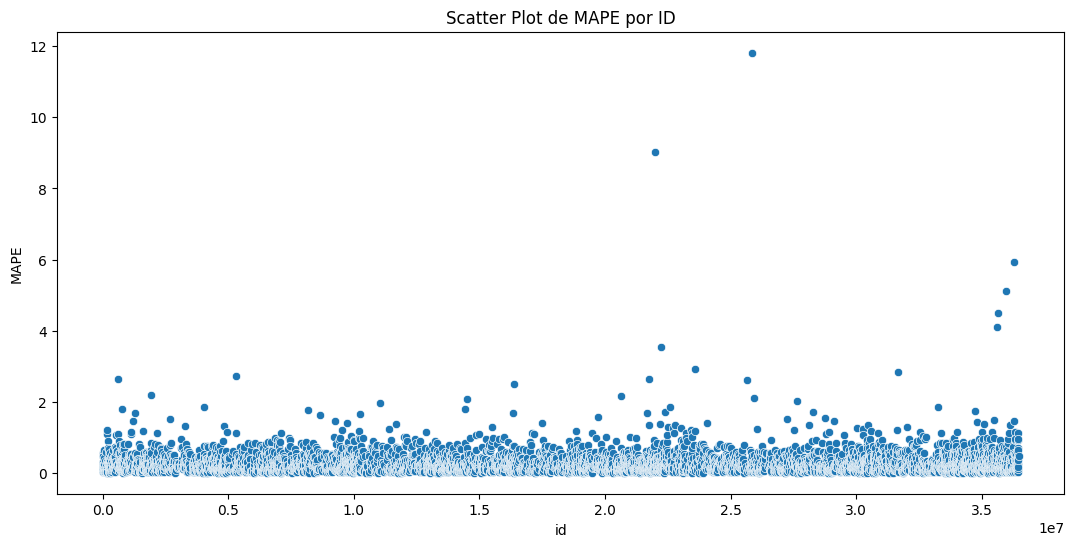

In [46]:
aux=df92.drop(df92[df92['id'] == 21304320].index, axis=0)

# px.scatter(aux,x='id',y='MAPE',height=500)

plt.figure(figsize=(13, 6))  
sns.scatterplot(x='id', y='MAPE', data=aux)
plt.title('Scatter Plot de MAPE por ID')
plt.show()

## **Total performance**

In [51]:
df93=(df92[['price','predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum (x),axis=0)
                                                                    .reset_index()
                                                                    .rename(columns={'index':'Scenario',0:'Values'}))
df93['Values']=df93['Values'].map('${:,.2f}'.format)
df93

,Scenario,Values
0,price,"$725,918.00"
1,predictions,"$619,381.01"
2,worst_scenario,"$367,015.20"
3,best_scenario,"$871,746.89"


## **Machine learning performance**

In [52]:
df9['error']=df9['price']-df9['predictions']

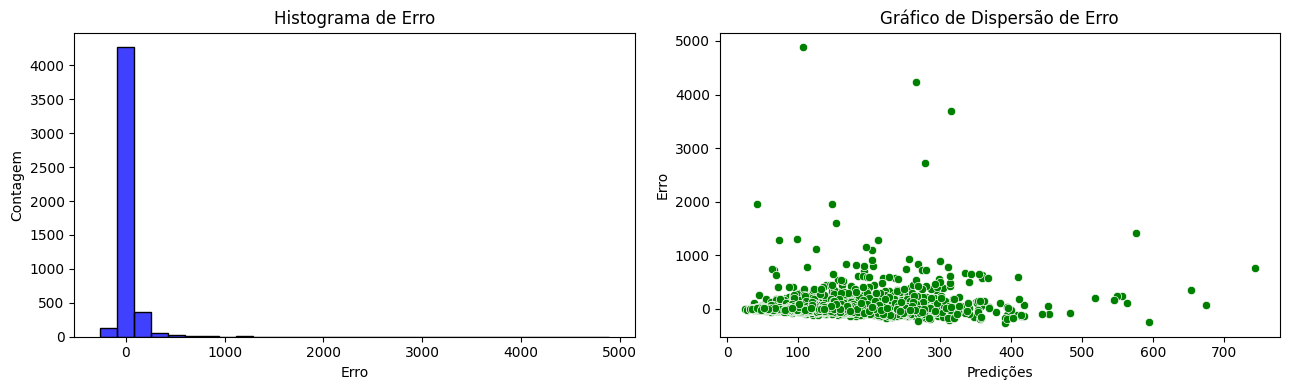

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(13, 4))

sns.histplot(df9['error'], bins=30, color='blue', ax=axs[0])
axs[0].set_title('Histograma de Erro')
axs[0].set_xlabel('Erro')
axs[0].set_ylabel('Contagem')

sns.scatterplot(x='predictions', y='error', data=df9, color='green', ax=axs[1])
axs[1].set_title('Gráfico de Dispersão de Erro')
axs[1].set_xlabel('Predições')
axs[1].set_ylabel('Erro')

plt.tight_layout()
plt.show()

# **10 Entregas**

## **1**

Faça uma análise exploratória dos dados (EDA), demonstrando as principais características entre as variáveis e   
apresentando algumas hipóteses de negócio relacionadas. Seja criativo!

A resposta está contida na seção 4 - Exploratory data analysis

## **2**

### a) Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, 
### onde seria mais indicada a compra?

Pensando na compra de um apartamento, seria no bairro_group Bronx, porque, segundo pesquisas, é o local mais acessível de Nova York    
para se comprar um apartamento, e tentando maximizar o lucro, um apartamento cujo preço de aluguel está acima do 2° quartil (maior que 50% dos preços).  

É necessário também escolher um apartamento cujo número de reviews esteja acima da média, o que sinaliza um local facilmente alugado.

Para aumentar a acurácia desse recomendação, seria necessário analisar os valores de compra dos apartamentos.

In [ ]:
# somente no Bronx e número de reviews superior à média geral
aux=df4[(df4['bairro_group']=='Bronx') & (df4['price']>106) & (df4['numero_de_reviews']>23)]

# filtrando apenas apartamentos
keywords = ['Apartment', 'apartment', 'Apt', 'apt']
filter = aux['nome'].str.contains('|'.join(keywords), case=False)
aux = aux[filter]

aux1=aux[['nome','bairro','room_type','price','numero_de_reviews']]
aux1.sort_values('price',ascending=False).head(10).reset_index(drop=True)

### b) O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Segundo os resultados já mencionados na EDA, não parece haver uma relação considerável entre o mínimo de noites e a disponibilidade com o preço

### c) Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Sim, existem algumas palavras que se repetem quando se filtra os imóveis com os maiores aluguéis.

Luxury - 5 vezes   
Beautiful - 4 vezes  
SuperBowl - 3 vezes   
Private - 3 vezes   
Townhouse - 3 vezes  
Film - 3 vezes 

**As palavras foram contadas com a ajuda de uma IA com base numa lista dos 50 imóveis com os maiores preços**   
(essas palavras não foram encontradas na lista dos 50 imóveis mais baratos, conforme análise da variável na Bivariate analysis)

## **3**

Explique como você faria a previsão do preço a partir dos dados.    
Quais variáveis e/ou suas transformações você utilizou e por quê?    
Qual tipo de problema estamos resolvendo (regressão, classificação)?    
Qual modelo melhor se aproxima dos dados e quais seus prós e contras?    
Qual medida de performance do modelo foi escolhida e por quê?

- a) Quais variáveis e/ou suas transformações você utilizou e por quê?    

As variáveis criadas na feature engineering não foram úteis para o modelo, e das variáveis originais, optei por manter     
o menor número de variáveis possível, tentando manter o melhor desempenho, pensando num possível ambiente de produção, tornando o modelo    
menos complexo e mais robusto.    

Nas variáveis categóricas, eu usei onehot encoding para as de baixa cardinalidade (para melhor representar cada registro individualmente) e    
target encoding nas de alta cardinalidade (para evitar aumentar a dimensionalidade e considerar a relação com a variável resposta).    

Nas variáveis númerias, as técnicas de reescala não aumentaram a performance do modelo, então optei por não realizar essas transformações,   
exceto para a variável resposta, na qual usei np.log1 (para aproximar a distribuição de uma normal), aumentando a performance do modelo.    

- b) Qual tipo de problema estamos resolvendo (regressão, classificação)?    


O problema é de regressão, ou seja, prever um valor contínuo com base em sua relação com as variáveis independentes.   

- c) Qual modelo melhor se aproxima dos dados e quais seus prós e contras?    

O modelo que mais se aproximou dos dados foi o CatBoostRegressor.   

Prós: Rápido para treinar/tunar e gera um arquivo pkl leve, característica útil em produção.    

Contras: Difícil explicabilidade, no problema eu presumi que a performance seria mais importante que a explicabilidade,    
porém num cenário real pode acabar não sendo o caso se o problema de negócio envolver o contato com os donos dos imóveis ou possíveis clientes.   

- d) Qual medida de performance do modelo foi escolhida e por quê?

A métrica principal escolhida foi o MAE (erro médio absoluto).    

É fácil de interpretar e entender, facilita a compreensão do impacto no negócio e é robusto a outliers (importante característica nesse problema).    

## **4**

Supondo um apartamento com as seguintes características:

{'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',   
 'bairro_group': 'Manhattan',   
 'bairro': 'Midtown',   
 'latitude': 40.75362,   
 'longitude': -73.98377,   
 'room_type': 'Entire home/apt',   
 'price': 225,   
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',   
 'reviews_por_mes': 0.38,   
 'calculado_host_listings_count': 2,   
 'disponibilidade_365': 355}   

Qual seria a sua sugestão de preço?

In [71]:
# previsão do modelo

df_raw=pd.read_csv('../datasets/raw.csv')

model=pickle.load(open('../model/model_lighthouse.pkl','rb'))
standard_scaler=pickle.load(open('../parameters/standard.pkl','rb'))
power_trans=pickle.load(open('../parameters/power_trans.pkl','rb'))
target_bairro=pickle.load (open('../parameters/target_bairro.pkl','rb'))
target_room_type=pickle.load (open('../parameters/target_room_type.pkl','rb'))
target_bairro_group=pickle.load (open('../parameters/target_bairro_group.pkl','rb'))

x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df_raw, 
                                                        target = 'price', 
                                                        train_size=0.8, valid_size=0.1, test_size=0.1,
                                                        random_state=42)

dict = {'id': 2595,
             'nome': 'Skylit Midtown Castle',
             'host_id': 2845,
             'host_name': 'Jennifer',
             'bairro_group': 'Manhattan',
             'bairro': 'Midtown',
             'latitude': 40.75362,
             'longitude': -73.98377,
             'room_type': 'Entire home/apt',
             'minimo_noites': 1,
             'numero_de_reviews': 45,
             'ultima_review': '2019-05-21',
             'reviews_por_mes': 0.38,
             'calculado_host_listings_count': 2,
             'disponibilidade_365': 355}

df = pd.DataFrame([dict])

test = x_test.copy()
test = pd.concat([test, df], ignore_index=True)

# change types
test['ultima_review'] = pd.to_datetime(test['ultima_review'])

# nas
test['reviews_por_mes'] = np.where(test['reviews_por_mes'].isna(), 0, test['reviews_por_mes'])
cols = ['nome','host_name']
test[cols] = np.where(test[cols].isna(), 'desconhecido', test[cols])

# feature engineering
test['ultima_review'] = test['ultima_review'].fillna('2019-07-09')
ref_date = pd.to_datetime('2019-07-09')
test['ultima_review'] = (test['ultima_review'] - ref_date).dt.days * -1

test=target_bairro.transform(test)
test=target_room_type.transform(test)
test=target_bairro_group.transform(test)

Test=test[['bairro', 'bairro_group','ultima_review','latitude','longitude',
       'minimo_noites', 'numero_de_reviews', 'calculado_host_listings_count',
       'disponibilidade_365', 'room_type','reviews_por_mes']]

Test['id']=test['id']

pred = model.predict(Test)

pred= standard_scaler.inverse_transform(pred.reshape(-1, 1))
pred= inv_boxcox1p(pred, power_trans.lambdas_).flatten()
Test['pred']=pred

print(f'A previsão do modelo para o preço é: {Test.loc[Test["id"] == 2595, "pred"].values[0]}')

A previsão do modelo para o preço é: 291.35978506277735


In [1394]:
# estatísticas de preço para o bairro group Manhattan
aux=df4[df4['bairro_group']=='Manhattan']
print(aux['price'].mean())
print(aux['price'].median())
print(aux['price'].std())

print('\n')
# estatísticas de preço para o bairro Midtown
aux=df4[df4['bairro']=='Midtown']
print(aux['price'].mean())
print(aux['price'].median())
print(aux['price'].std())

print('\n')
# estatísticas de preço para room type Entire home/apt
aux=df4[df4['room_type']=='Entire home/apt']
print(aux['price'].mean())
print(aux['price'].median())
print(aux['price'].std())

198.03929104049558
150.0
290.5305063321215


287.97617156473393
210.0
269.4626834026183


213.24911626080126
160.0
291.0759384482693


O preço original de 225 está de acordo com as médias para as suas principais características (bairro group,   
bairro e room type), mas poderia ser esticado um pouco mais, até 300-400 devido a média de aluguéis para o bairro Midtown ser de 287 e o   
desvio padrão ser alto (bem como nas demais características), e também se tratando de um imóvel com um alto número de reviews,     
provavelmente requisitado.   

Portanto, a previsão do modelo de $291 é realista, apesar de ser um pouco maior que o preço original de 225